In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path



# Define paths
RGB_img_dir = Path(r"D:\UNIVERSITY OF MORATUWA\releasev1-detection&tracking\releasev1-detection&tracking\RGB\images")
RGB_label_dir = Path(r"D:\UNIVERSITY OF MORATUWA\releasev1-detection&tracking\releasev1-detection&tracking\RGB\labels")
IR_img_dir = Path(r"D:\UNIVERSITY OF MORATUWA\releasev1-detection&tracking\releasev1-detection&tracking\IR\images")
IR_label_dir = Path(r"D:\UNIVERSITY OF MORATUWA\releasev1-detection&tracking\releasev1-detection&tracking\IR\labels")

#New dataset path
new_RGB_img_dir = Path(r"D:\UNIVERSITY OF MORATUWA\VIP-Cup-2025\YoloV8_RGB_Training\ArrangedDataset\RGB\images")
new_RGB_label_dir = Path(r"D:\UNIVERSITY OF MORATUWA\VIP-Cup-2025\YoloV8_RGB_Training\ArrangedDataset\RGB\labels")
new_IR_img_dir = Path(r"D:\UNIVERSITY OF MORATUWA\VIP-Cup-2025\YoloV8_RGB_Training\ArrangedDataset\IR\images")
new_IR_label_dir = Path(r"D:\UNIVERSITY OF MORATUWA\VIP-Cup-2025\YoloV8_RGB_Training\ArrangedDataset\IR\labels")

D:\UNIVERSITY OF MORATUWA\releasev1-detection&tracking\releasev1-detection&tracking\RGB\images\DRONE_034144_012_png.rf.85bf49ae910c0247defc3ea4b4370c22.jpg
Selected RGB image: DRONE_034144_012_png.rf.85bf49ae910c0247defc3ea4b4370c22.jpg


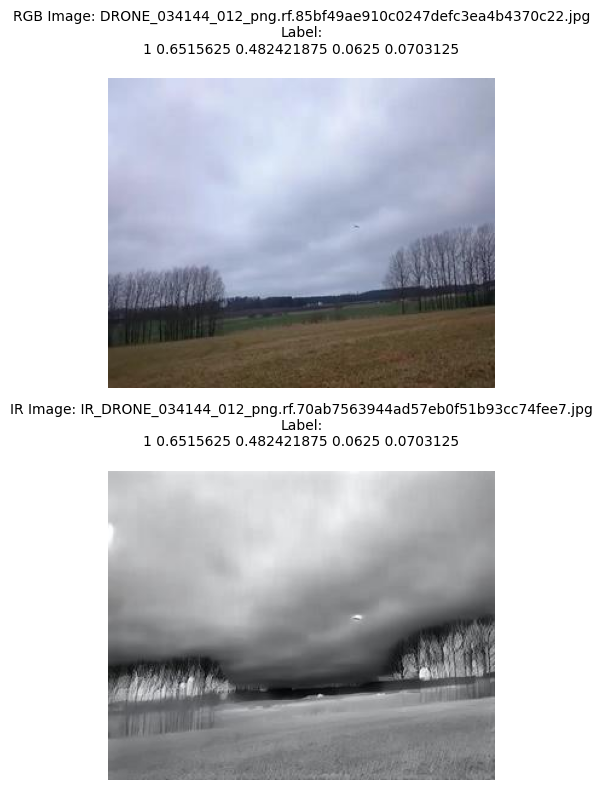

In [2]:
def showRandomImage():
    def get_base_name(filename):
        return filename.split(".rf")[0]

    # Get list of RGB images
    rgb_images = list(RGB_img_dir.glob("*.jpg"))
    if not rgb_images:
        raise Exception("No RGB images found!")

    # Pick a random RGB image
    rgb_path = random.choice(rgb_images)
    print(rgb_path)
    rgb_filename = rgb_path.name
    base_name = get_base_name(rgb_filename)
    print(f"Selected RGB image: {rgb_filename}")

    # Try to find corresponding IR image by matching base name
    ir_candidates = list(IR_img_dir.glob(f"IR_{base_name}.rf*.jpg"))
    ir_path = ir_candidates[0] if ir_candidates else None

    # Read RGB image
    rgb_img = cv2.imread(str(rgb_path))
    rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)

    # Read IR image if found
    ir_img = None
    if ir_path:
        ir_img = cv2.imread(str(ir_path))
        ir_img = cv2.cvtColor(ir_img, cv2.COLOR_BGR2RGB)

    # Read label text files
    rgb_label_path = RGB_label_dir / rgb_filename.replace('.jpg', '.txt')
    ir_label_path = IR_label_dir / ir_path.name.replace('.jpg', '.txt') if ir_path else None

    def read_label(label_path):
        return label_path.read_text() if label_path and label_path.exists() else "No label found."

    rgb_label = read_label(rgb_label_path)
    ir_label = read_label(ir_label_path)


    # Plot the images and labels
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # RGB image
    axs[0].imshow(rgb_img)
    axs[0].set_title(f"RGB Image: {rgb_filename}\nLabel:\n{rgb_label}", fontsize=10)
    axs[0].axis('off')

    # IR image or fallback
    if ir_img is not None:
        axs[1].imshow(ir_img)
        axs[1].set_title(f"IR Image: {ir_path.name}\nLabel:\n{ir_label}", fontsize=10)
    else:
        axs[1].text(0.5, 0.5, "IR image not found", ha='center', va='center', fontsize=12)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    # Set random seed for reproducibility
    showRandomImage()

In [5]:
import cv2
from pathlib import Path
from ultralytics import YOLO

def drawboundingbox_with_contours(image, label_path):
    h, w, _ = image.shape

    if label_path.exists():
        with open(label_path, "r") as f:
            for line in f:
                cls_id, x_center, y_center, bw, bh = map(float, line.strip().split())
                
                # Convert normalized coordinates to pixel values
                x1 = int((x_center - bw / 2) * w)
                y1 = int((y_center - bh / 2) * h)
                x2 = int((x_center + bw / 2) * w)
                y2 = int((y_center + bh / 2) * h)
                
                
                # Crop the region inside the bounding box
                roi = image[y1:y2, x1:x2]

                # Convert to grayscale and apply threshold for contour detection
                gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                
                # Find contours in the ROI
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                # Offset contours and draw them on the original image
                for cnt in contours:
                    # Offset contour to match full image coordinates
                    cnt[:, 0, 0] += x1
                    cnt[:, 0, 1] += y1

                    # Calculate area of contour
                    contour_area = cv2.contourArea(cnt)
                    #print(f"Contour area: {contour_area}")

                    # Draw the contour
                    #cv2.drawContours(image, [cnt], -1, (255, 0, 0), 1)
                
                # Draw bounding box
                #cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                rect_area = (x2 - x1) * (y2 - y1)
                #print(f"Rectangle area: {rect_area}")
                
    return image,contour_area


In [6]:
def showImages():
    def get_base_name(filename):
        return filename.split(".rf")[0]

    # Get list of RGB images
    rgb_images = list(RGB_img_dir.glob("*.jpg"))
    if not rgb_images:
        raise Exception("No RGB images found!")

    for path in rgb_images[0:1000]:
        rgb_path = path
        rgb_filename = rgb_path.name
        base_name=get_base_name(rgb_filename)

        ir_candidates = list(IR_img_dir.glob(f"IR_{base_name}.rf*.jpg"))
        ir_path = ir_candidates[0] if ir_candidates else None
        
        rgb_img = cv2.imread(str(rgb_path))
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)

        ir_img = None
        if ir_path:
            ir_img = cv2.imread(str(ir_path))
            ir_img = cv2.cvtColor(ir_img, cv2.COLOR_BGR2RGB)
        
        rgb_label_path = RGB_label_dir / rgb_filename.replace('.jpg', '.txt')
        ir_label_path = IR_label_dir / ir_path.name.replace('.jpg', '.txt') if ir_path else None

        def read_label(label_path):
            return label_path.read_text() if label_path and label_path.exists() else "No label found."
        rgb_label = read_label(rgb_label_path)
        ir_label = read_label(ir_label_path)

        # Draw bounding boxes on the images
        rgb_img,rgb_area = drawboundingbox_with_contours(rgb_img, rgb_label_path)       
        if ir_img is not None:
            ir_img,ir_area = drawboundingbox_with_contours(ir_img, ir_label_path)

        if(10<ir_area):
            matching_rgb_files = list(RGB_img_dir.glob(f"{base_name}.rf*.jpg"))
            matching_ir_files = list(IR_img_dir.glob(f"IR_{base_name}.rf*.jpg"))

            new_rgb_path = new_RGB_img_dir / rgb_filename
            new_ir_path = new_IR_img_dir / ir_path.name
            new_rgb_label_path = new_RGB_label_dir / rgb_filename.replace('.jpg', '.txt')
            new_ir_label_path = new_IR_label_dir / ir_path.name.replace('.jpg', '.txt')

            cv2.imwrite(str(new_rgb_path), rgb_img)
            cv2.imwrite(str(new_ir_path), ir_img)
            #print(base_name)
            new_rgb_label_path.write_text(rgb_label)
            new_ir_label_path.write_text(ir_label)

            for file in matching_ir_files:
                if(file.name not in new_ir_path.name):
                    new_ir_path = new_IR_img_dir / file.name
                    cv2.imwrite(str(new_ir_path), ir_img)
                    new_ir_label_path = new_IR_label_dir / file.name.replace('.jpg', '.txt')
                    new_ir_label_path.write_text(ir_label)
                    #print(f"Matching IR file: {file.name}")
                    

                
            
            

        else:
            #print(f"Contour area is too small: {ir_area} for {ir_path.name}")
            pass


    print(len(rgb_images))

if __name__ == "__main__":
    # Set random seed for reproducibility
    showImages()

57580


In [ ]:
# Collect and shuffle all image paths
RGBimage_files = sorted([f for f in Path(new_RGB_img_dir).glob("*.jpg")])
print(f"Total RGB images found: {len(RGBimage_files)}")

RGBlabel_files = sorted([f for f in Path(new_RGB_label_dir).glob("*.txt")])
print(f"Total RGB Labels found: {len(RGBlabel_files)}")

IRimage_files = sorted([f for f in Path(new_IR_img_dir).glob("*.jpg")])
print(f"Total IR images found: {len(IRimage_files)}")

IRlabel_files = sorted([f for f in Path(new_IR_label_dir).glob("*.txt")])
print(f"Total IR Labels found: {len(IRlabel_files)}")



Total RGB images found: 564
Total RGB Labels found: 564
Total IR images found: 564
Total IR Labels found: 564
